In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
import tensorflow.keras.backend as K
from winfoGAN.model import GAN
from classifier.classifier import CLASSIFICATION_MODEL
import librosa as lb
from IPython.lib.display import Audio
import IPython
import pandas as pd
import json

import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram
from collections import Counter

In [2]:
def create_inputs(specs, num, bit_value= 1, baseline_dose = 0, random = False):
    latent_dim = specs["Latent Dim"]
    n_cat = specs["N Categories"]
    bits = range(n_cat)
    z_dim = latent_dim-n_cat

    if random:
        #print("Random c")
        z= tf.random.normal(shape=(num, z_dim))
        c = tf.random.normal(shape=(num, n_cat))
        #thresholding values to 0 and 1
        c = tf.cast(c < 0, dtype=tf.float32)
        inputs = [tf.concat([z,c], axis=1)]

    else:
        inputs = []
        for bit in bits:
            z= np.random.normal(size=(num, latent_dim))
            z[:,z_dim:]= baseline_dose
            z[:,z_dim+bit]=bit_value
            z= tf.convert_to_tensor(z, dtype=tf.float32)
            inputs.append(z)


    return inputs

In [6]:
gan_directory ="C:/Users/Jayde/Desktop/wavegan/m5"
spec_path = f"{gan_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  specs = json.load(f)

classifier_directory ="C:/Users/Jayde/Desktop/wavegan/m_cls1"
spec_path = f"{classifier_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  classifier_specs = json.load(f)

In [7]:
gan = GAN(
    latent_dim = specs["Latent Dim"],
    discriminator_steps= specs["Discriminator Steps"],
    gp_weight= specs["GP Weight"],
    n_categories= specs["N Categories"],
    slice_len=16384,
)

classifier = CLASSIFICATION_MODEL(
   n_categories = classifier_specs["N Categories"],
   slice_len = classifier_specs["Slice Length"]
)

classifier = classifier.classifier
generator = gan.generator

In [8]:
classifier.load_weights(f"{classifier_directory}/classifier10")
generator.load_weights(f"{gan_directory}/generator600")

22/22 [==============================] - 45s 2s/step


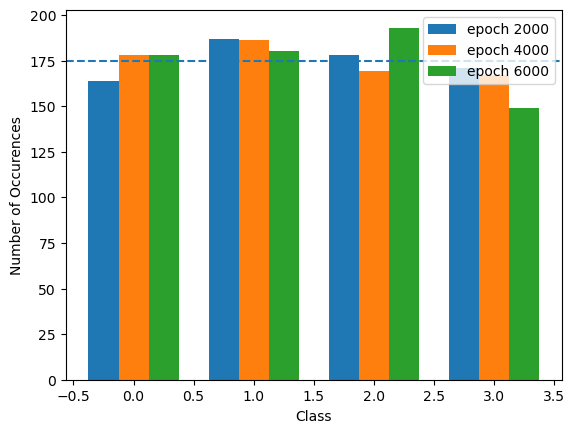

In [11]:
width=0.25
multiplier=-1
N=700

for epoch in ["2000","4000","6000"]:
    offset = width * multiplier
    generator.load_weights(f"{gan_directory}/generator{epoch}")
    epoch = "5000" if epoch =="" else epoch
    inputs = create_inputs(specs,N,bit_value= 1, random =True)[0]
    generated_audio = generator.predict(inputs) 
    audio= np.squeeze(generated_audio)
    pred_labels = np.argmax(classifier.predict(audio), axis=1)
    count =Counter(pred_labels)
    plt.bar(np.array(list(count.keys()),dtype= int)+offset,count.values(), label=f"epoch {epoch}",width=width)
    multiplier +=1
plt.axhline(N/4,linestyle="dashed")
plt.xlabel("Class")
plt.ylabel("Number of Occurences")
plt.legend()
fig_dir = f"{gan_directory}/class_occurences.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()

    

In [13]:
pred_labels

array([2, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 2, 1, 3, 3, 2, 2, 3, 2, 0, 0, 1,
       1, 0, 0, 2, 3, 1, 2, 0, 1, 1, 2, 0, 3, 3, 1, 1, 3, 3, 1, 0, 0, 3,
       1, 2, 3, 0, 0, 3, 3, 2, 1, 0, 0, 0, 1, 2, 2, 1, 3, 3, 1, 0, 3, 2,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 3, 3, 2, 0, 0, 2, 3, 2, 0, 0, 2, 2,
       3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 0, 2, 0, 2, 2, 1, 3, 0,
       1, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 1, 0, 0, 0, 3, 1, 1, 0, 0, 0, 0,
       1, 2, 3, 1, 0, 1, 2, 3, 2, 0, 0, 2, 0, 1, 0, 3, 3, 1, 3, 3, 2, 3,
       2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 1, 3, 0, 2, 3, 2, 3, 0, 3, 1, 1, 0,
       1, 1, 0, 2, 1, 2, 3, 2, 0, 3, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 3, 2, 1, 2, 1, 3, 1, 3, 1, 2, 2, 3, 2,
       1, 0, 2, 3, 2, 2, 1, 3, 1, 2, 0, 3, 0, 0, 2, 0, 3, 3, 0, 2, 0, 0,
       1, 0, 1, 0, 2, 3, 1, 0, 3, 3, 1, 0, 0, 1, 3, 2, 0, 1, 3, 3, 1, 0,
       3, 0, 2, 0, 3, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 3, 2, 3, 2, 0, 0, 1,
       1, 2, 0, 2, 0, 2, 1, 0, 0, 2, 2, 1, 3, 0, 3,

In [14]:
count =Counter(pred_labels)

In [15]:
count
from collections import defaultdict
classifications = defaultdict(list)

In [17]:
n=700

for key, value in count.items():
    frac= value/n
    print(frac)
    classifications[key].append(frac)

0.2757142857142857
0.21285714285714286
0.2542857142857143
0.2571428571428571


In [19]:
classifications

defaultdict(list,
            {1: [0.27, 0.27], 3: [0.26, 0.26], 0: [0.3, 0.3], 2: [0.17, 0.17]})